# Logistic distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
set.seed(12345)
s <- 200

In [3]:
Z <- rmvevd(10000, dep = .5, model = "log", d = 2, mar = c(1,1,1))

In [4]:
Z2 <- rmstable(10000, d = 2, par = matrix(c(0, .6, .6, 0), 2, 2))

In [5]:
A <- matrix(c(0.8, 0.6, 0.05, 0.45, 0.2, 0.4, 0.95, 0.55), 4, 2)
X <- t(maxmatmul(A, t(Z)))
X2 <- t(maxmatmul(A, t(Z2)))

In [6]:
A

0.80,0.20
0.60,0.40
0.05,0.95
0.45,0.55


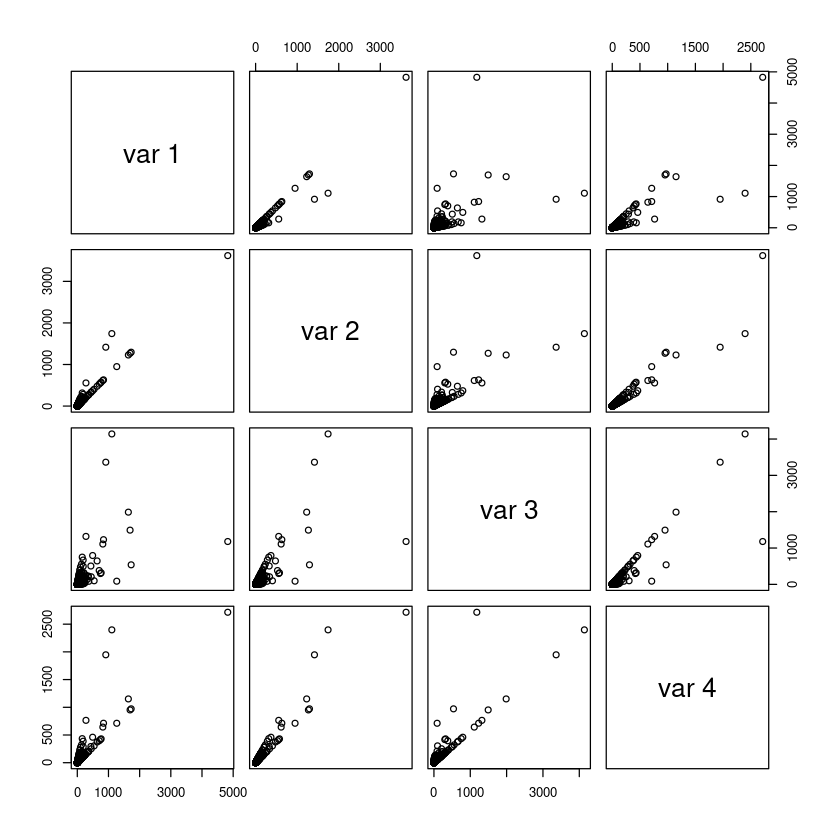

In [7]:
pairs(X)

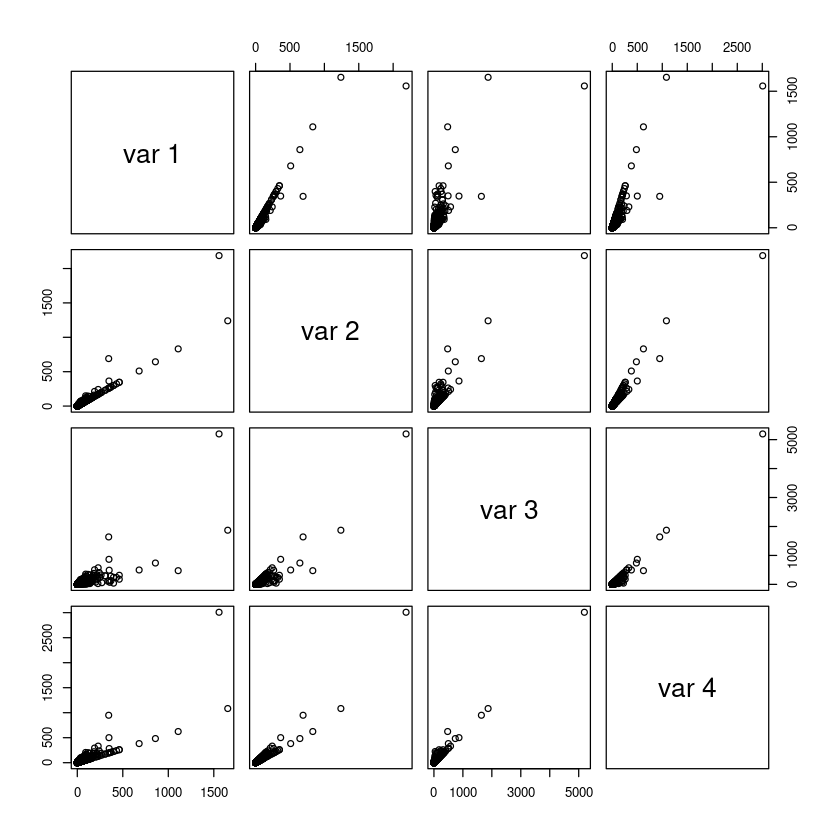

In [8]:
pairs(X2)

In [9]:
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

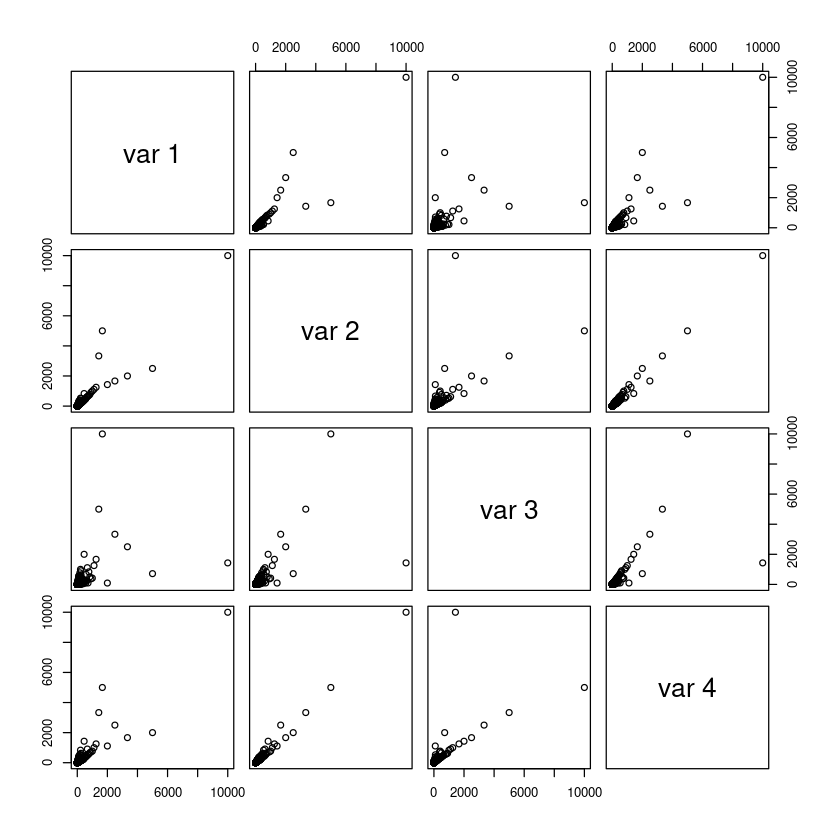

In [10]:
pairs(Xtrafo)

In [11]:
summary(rowSums(Xtrafo))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    4.003     5.545     8.225    39.150    16.384 31428.571 

In [12]:
length(which(rowSums(Xtrafo) > s))

[1] 201

In [13]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 2000)
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 2000)
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 2000)
maxPCA4 <- max_stable_prcomp(Xtrafo, p = 4, s = s, n_initial_guesses = 2000)

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.



In [14]:
maxPCA2

$p
[1] 2

$d
[1] 4

$decoder_matrix
            [,1]      [,2]
[1,] 1.032673026 0.1434531
[2,] 0.864392096 0.6376813
[3,] 0.007520281 1.1293867
[4,] 0.655402732 0.8694527

$encoder_matrix
           [,1]       [,2]       [,3]       [,4]
[1,] 0.96836535 0.26917102 0.08168338 0.07723895
[2,] 0.00140107 0.02329669 0.88543221 0.06727504

$reconstr_matrix
            [,1]       [,2]      [,3]       [,4]
[1,] 1.000004781 0.27796566 0.1270180 0.07976258
[2,] 0.837047358 0.23266931 0.5646235 0.06676474
[3,] 0.007282379 0.02631097 0.9999954 0.07597953
[4,] 0.634669299 0.17641542 0.7698415 0.05849247

$loss_fctn_value
[1] 0.08558645

$optim_conv_status
[1] 4

$s
[1] 200

$starting_vals
$starting_vals$encoder_matrix_x0
          [,1]      [,2]
[1,] 1.0000000 0.8000000
[2,] 0.8848660 0.7515364
[3,] 0.5275200 1.0000000
[4,] 0.7053391 0.8624064

$starting_vals$decoder_matrix_xo
          [,1]      [,2]
[1,] 0.9924958 0.4888534
[2,] 0.2120095 0.8729457
[3,] 0.8003867 0.8730065
[4,] 0.5674432 0.754624

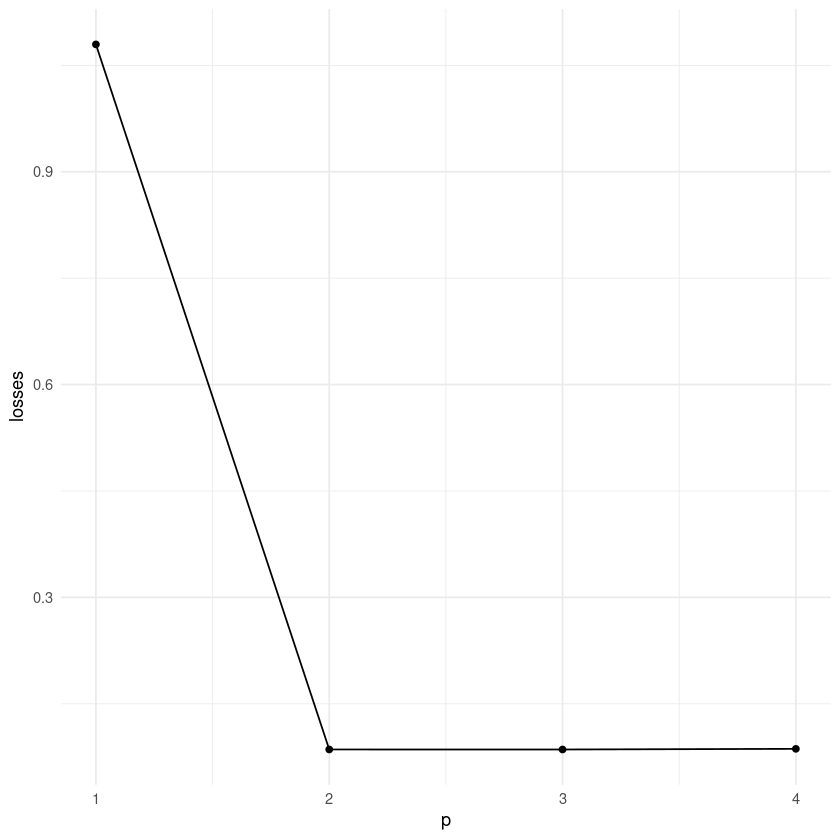

In [15]:
plotdat <- data.frame(p = 1:4, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value,
    maxPCA4$loss_fctn_value   
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + geom_line() + geom_point() + theme_minimal()
pe

In [16]:
ggsave("genmlm_elbow.png", pe)

Saving 6.67 x 6.67 in image


In [17]:
rec <- t(maxmatmul(maxPCA2$reconstr_matrix, t(X)))

In [18]:
datX <- data.frame(X)
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, X4, is_rec)`


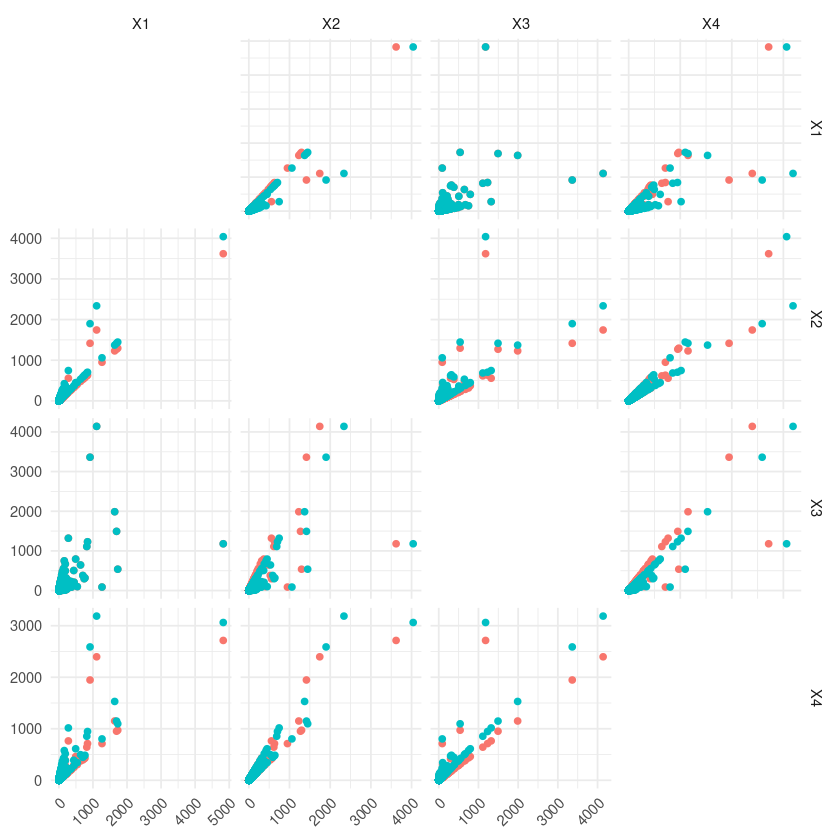

In [19]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec),
    columns = 1:4,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_minimal() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

In [20]:
plot_datX %>% group_by(is_rec) %>% summarize(max(X1))

is_rec,max(X1)
<chr>,<dbl>
original,4825.839
reconstruction,4825.862


In [21]:
ggsave("genmlm.png", p)

Saving 6.67 x 6.67 in image
